# How to Make a Racist AI Without Really Trying
### A cautionary tutorial

Implementing the code for creating a simple sentiment classifier using NLP tools, found on Speer (2017)'s blog post [here](http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/). We do this as a way to both see some NLP tools in action, as well as to examine what happens when we use these tools without really taking into account where the data we use comes from, or who it could affect in the long run.

Here’s the outline, taken from the blog post:

- Get word embeddings to represent the meanings of words
- Pull training and test data, with gold-standard annotated examples of positive and negative words
- Train a classifier to recognize other positive and negative words based on their word embeddings
- Compute sentiment scores for sentences of text using this classifier
- Behold the monstrosity that we have created

After we do that, we'll also:

Look at the problem and measure it statistically
Improve the data and retrain the model to hopefully get a more accurate and less racist result

## Installing the basics

We'll need some python packages to do this, and the following cell is our setup & background for building this tutorial.

In [2]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

Mon Mar  7 17:00:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1: Word embeddings

The first step in this process to this is to get word embeddings. 

**What are word embeddings?**

- A measure of semantic similarity based on word distribution properties in a text
- A way to represent a word in terms of a numerical value, encoded as a *vector* 
- What's a vector?
  - Basically, objects that can be added or multiplied, and which has a length and a direction.

**Why do we want to calculate them?**

- Because you can then compare words by looking at their similarities, encoded as numerical values.

*An aside: have you played [Semantle](https://semantle.novalis.org/) yet? This is a good representation of word embedding/similarities values of English words.This is based off of word2vec embeddings.*


In the article, the author uses the GloVe pretrained word embedding model. They download it from [here](https://nlp.stanford.edu/projects/glove/) ([this](https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip) is the link to the actual zip). To keep following along, download that file, save it as `glove.42B.300d.txt` and place it in your accessible file directory.

This is a big file! And this block of code takes about 5 minutes to run.

In [4]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('/content/drive/MyDrive/Colab Notebooks/glove.42B.300d.txt')
embeddings.shape

(1917495, 300)

## Step 2: Import positive & negative sentiment words

We'll need some sentiment data. The original paper took this from Bing Liu’s web site (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon), but I wasn't able to download it there. I found the same set here:

- [Positive sentiment words](https://ptrckprry.com/course/ssd/data/positive-words.txt)
- [Negative sentiment words](https://ptrckprry.com/course/ssd/data/negative-words.txt)

We'll save these in an accessible place (make sure to update your file paths) and load these lexicons.

In [5]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('/content/drive/MyDrive/Colab Notebooks/positive-words.txt')
neg_words = load_lexicon('/content/drive/MyDrive/Colab Notebooks/negative-words.txt')


## 3. Train a Model to recognize positive & negative sentiment 

So now that we have positive & negative words, we have to do a little clean up to get rid of the words that *are* in the lists, but aren't in the embeddings dictionary. This takes a bit of time to run.

In [6]:
pos_vectors = embeddings.loc[[x for x in pos_words if x in list(embeddings.index)]].dropna()
neg_vectors = embeddings.loc[[x for x in neg_words if x in list(embeddings.index)]].dropna()


And once we've gotten these cleaned lists, we can then make arrays of the  inputs and outputs. The inputs are the embeddings, and the outputs are coded as 1 for positive words and -1 for negative words.

In [7]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

We need to separate our data into training data and test data, where 90 % of the data is training, and 10% is reserved for testing:

In [8]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

model = SGDClassifier(loss='log', random_state=0)
model.fit(train_vectors, train_targets)

accuracy_score(model.predict(test_vectors), test_targets)

0.9411764705882353

Define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data

In [9]:

def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    filtered_words = [word for word in words if word in list(embeddings.index)]
    vecs = embeddings.loc[filtered_words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels)

,sentiment
fictional,-1.440770
intermittent,-11.439193
inviolate,0.403017
blockage,-7.607734
taxing,-0.375859
...,...
enslave,-2.956712
shemale,-1.230915
sillily,-2.910008
intimidate,-8.700249


# Step 4: Get a sentiment score for text



Let's write a little function that will calculate the sentiment of a string of text.

In [10]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

## 5. Behold the monstrosity we have created

In [ ]:
text_to_sentiment("Any text can go here, and we can get a sentiment score")

Let's see how it does with sentences whose polarity is reversed:

In [ ]:
text_to_sentiment("I love cats")

In [ ]:
text_to_sentiment("I don't love cats")

In [ ]:
text_to_sentiment("Let's go on a ghost tour")

In [ ]:
text_to_sentiment("Let's not go on a ghost tour")

Let's look at this one -- do we expect this given how "sentiment" is defined? 

(think: just the mean of the sentiment scores of each word)

In [ ]:
text_to_sentiment("I'm going to die")

In [ ]:
text_to_sentiment("I'm not going to die")

We'll see if we can get the same results with names that Speer (2017) did:

In [ ]:
text_to_sentiment("My name is Emily")

In [ ]:
text_to_sentiment("My name is Heather")

In [ ]:
text_to_sentiment("My name is Yvette")

In [ ]:
text_to_sentiment("My name is Shaniqua")

# 😬  yikes, we do get the same results.

# How can we fix this?

In [11]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Samar', 'Ahmad', 'Zikri', 'Rasaan', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
    
}

In [12]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

In [74]:
name_sentiments

,sentiment,group
mohammed,-1.434436,Arab/Muslim
omar,-4.479778,Arab/Muslim
ahmed,2.113367,Arab/Muslim
ali,1.478598,Arab/Muslim
youssef,1.091548,Arab/Muslim
...,...,...
colleen,0.810645,White
emily,5.683485,White
megan,2.647111,White
rachel,1.529539,White


(-10.0, 10.0)

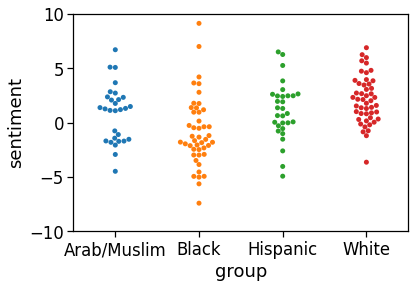

In [13]:
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

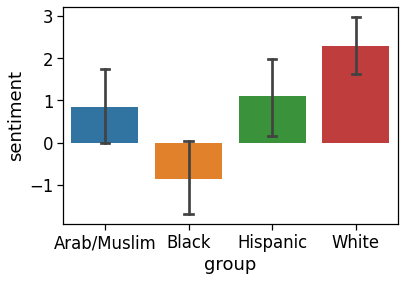

In [14]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

In [15]:
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]

Dep. Variable:,sentiment,R-squared:,0.172
Model:,OLS,Adj. R-squared:,0.155
Method:,Least Squares,F-statistic:,10.32
Date:,"Mon, 07 Mar 2022",Prob (F-statistic):,3.25e-06
Time:,18:06:43,Log-Likelihood:,-370.41
No. Observations:,153,AIC:,748.8
Df Residuals:,149,BIC:,760.9
Df Model:,3,,
Covariance Type:,nonrobust,,


In [16]:
ols_model.fvalue


10.324123824642829

In [17]:
def retrain_model(new_embs):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    global model, embeddings, name_sentiments
    embeddings = new_embs
    pos_vectors = embeddings.loc[[x for x in pos_words if x in list(embeddings.index)]].dropna()
    neg_vectors = embeddings.loc[[x for x in neg_words if x in list(embeddings.index)]].dropna()
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
        
    model = SGDClassifier(loss='log', random_state=0)
    model.fit(train_vectors, train_targets)
    
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    
    name_sentiments = name_sentiment_table()
    ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
    print("F-value of bias: {:.3f}".format(ols_model.fvalue))
    print("Probability given null hypothesis: {:.3}".format(ols_model.f_pvalue))
    
    # Show the results on a swarm plot, with a consistent Y-axis
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])

Accuracy of sentiment: 94.12%
F-value of bias: 10.324
Probability given null hypothesis: 3.25e-06


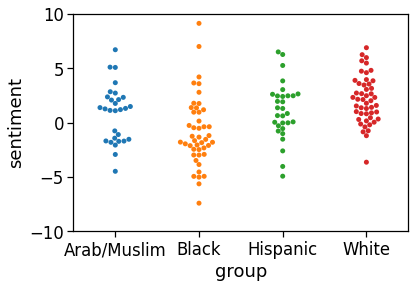

In [18]:
retrain_model(embeddings)